In [232]:
import torch
import numpy as np

from tqdm import tqdm
from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

In [233]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "clean"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 10_000

In [234]:
if DAFX_NAME.lower() == "clean":
    dafx = NullDAFXWrapper()
else:
    dafx = load_plugin(DAFX_FILE, plugin_name=DAFX_NAME)
    dafx = DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [270]:
def audio_to_spectrogram(signal: torch.Tensor,
                         n_fft: int = 4096,
                         hop_length: int = 2048,
                         window_size: int = 4096,
                         return_phase: bool = True):

    bs, _, _ = signal.size()

    window = torch.nn.Parameter(torch.hann_window(window_size))

    X = torch.stft(
            signal.view(bs, -1),
            n_fft=n_fft,
            hop_length=hop_length,
            window=window,
            return_complex=True,
        )

    # Absolute value part
    X_db = torch.pow(X.abs() + 1e-8, 0.3)
    X_db_norm = X_db

    # Normalise (0,1)
    X_db_norm -= 0.3352797
    X_db_norm /= 0.2745147

    X_db_norm = X_db_norm.unsqueeze(1).permute(0, 1, 3, 2)

    # Angle part
    X_phase = torch.angle(X)
    X_phase_norm = X_phase

    # Normalise (0,1)
    X_phase_norm -= 0.0025563
    X_phase_norm /= 1.8219221

    X_phase = X_phase.unsqueeze(1).permute(0,1,3,2)

    return np.concat([X_db_norm, X_phase], dim=1)

In [236]:
dataset = PairedAudioDataset(
    dafx=dafx,
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    length=24_000*5,
    effect_input=False,
    effect_output=True,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 25011.77it/s]


Loaded 88 files for train = 66.89 hours.


In [237]:
# for batch in loader:
#     x, _ = batch
#
#     x_spec_complx = audio_to_spectrogram(x, return_complex=True)
#     x_spec = audio_to_spectrogram(x, return_complex=False)
#
#     print("Complex shape: ", x_spec_complx.shape)
#     print("Non-complex shape: ", x_spec.shape)
#
#     print("Real parts equal: ", torch.equal(x_spec_complx[:,0,:,:], x_spec[:,:,:,0]))
#     print("Imag parts equal: ", torch.equal(x_spec_complx[:,1,:,:], x_spec[:,:,:,1]))

In [259]:
batch = next(iter(loader))
x, y = batch

In [260]:
x_s, ang_x = audio_to_spectrogram(signal=x, return_complex=False)
y_s, ang_y = audio_to_spectrogram(signal=y, return_complex=False)

In [261]:
ang_x.shape

torch.Size([1, 1, 59, 2049])

In [262]:
X = torch.concat([x_s, ang_x, y_s, ang_y], dim=1)

In [263]:
X.shape

torch.Size([1, 4, 59, 2049])

In [264]:
X_hat = X

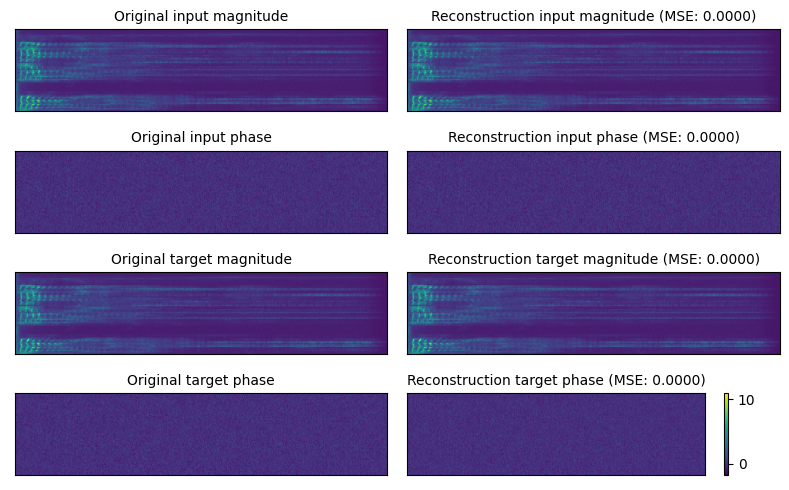

In [269]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(8,5))


mse = F.mse_loss(X, X_hat)

labels = ['input magnitude', 'input phase', 'target magnitude', 'target phase']

# find minimum of minima & maximum of maxima
minmin = torch.min(X).item()
maxmax = torch.max(X).item()

# for each dimension
for i in range(4):
    ax1 = axes[i, 0].imshow(X[0,i,:,:].detach().squeeze().numpy(), aspect='auto', vmin=minmin, vmax=maxmax)
    ax2 = axes[i, 1].imshow(X_hat[0,i,:,:].detach().squeeze().numpy(), aspect='auto', vmin=minmin, vmax=maxmax)

    axes[i, 0].set_title(f"Original {labels[i]}", fontsize=10)
    axes[i, 1].set_title(f"Reconstruction {labels[i]} (MSE: {mse.item():.4f})", fontsize=10)

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# fig.subplots_adjust(right=.85)
# cbar_ax = fig.add_axes([.9, 0.15, 0.05, 0.7])
# fig.colorbar(ax1, cax=cbar_ax)

plt.tight_layout()
# plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")
plt.colorbar(ax2)
plt.show()

In [245]:
stds = []
means = []

for batch in tqdm(loader):
    x, y = batch

    x_spec, x_ang = audio_to_spectrogram(x, return_complex=True)
    y_spec, y_ang = audio_to_spectrogram(y, return_complex=True)

    X = torch.concat([x_spec, x_ang, y_spec, y_ang], dim=1)

    # for each channel get mean and std
    m = X.mean(dim=(0,2,3))
    s = X.std(dim=(0,2,3))

    means.append(m.detach().numpy())
    stds.append(s.detach().numpy())

100%|██████████| 10000/10000 [00:50<00:00, 199.75it/s]


In [246]:
std_np = np.array(stds)
mean_np = np.array(means)

In [247]:
std_np.mean(axis=0)

array([0.9896877, 1.0000015, 0.9896877, 1.0000015], dtype=float32)

In [254]:
mean_np.mean(axis=0)

array([ 6.1210357e-03, -8.0166192e-06,  6.1210357e-03, -8.0166192e-06],
      dtype=float32)

In [255]:
print(std_np[:10])

[[1.0040345  0.99895316 1.0040345  0.99895316]
 [0.9977663  1.0002216  0.9977663  1.0002216 ]
 [0.8535296  1.0005149  0.8535296  1.0005149 ]
 [1.1303868  1.0002378  1.1303868  1.0002378 ]
 [1.0285367  0.9993014  1.0285367  0.9993014 ]
 [0.7434305  1.0003552  0.7434305  1.0003552 ]
 [0.8988427  0.9995829  0.8988427  0.9995829 ]
 [0.9959976  1.0001278  0.9959976  1.0001278 ]
 [1.0018734  0.9994555  1.0018734  0.9994555 ]
 [0.9947083  0.9996064  0.9947083  0.9996064 ]]


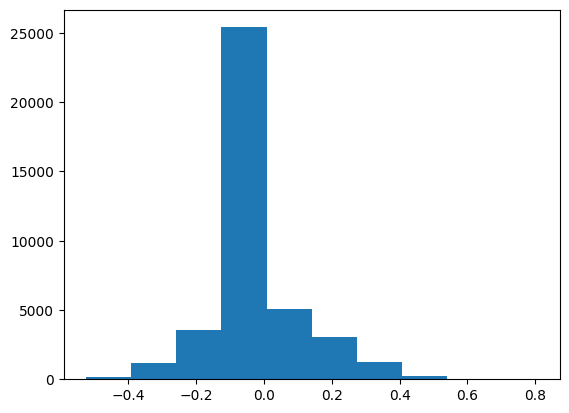

In [256]:
plt.hist(mean_np.ravel())
plt.show()

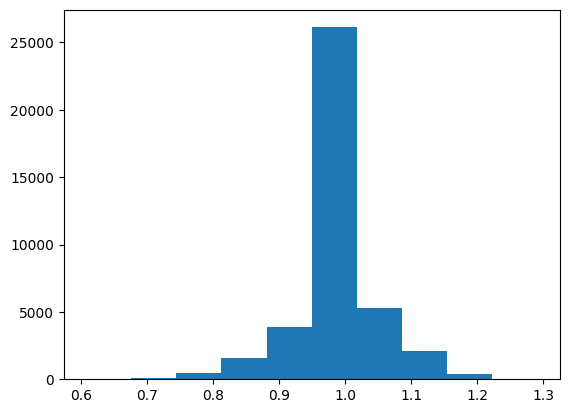

In [257]:
plt.hist(std_np.ravel())
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

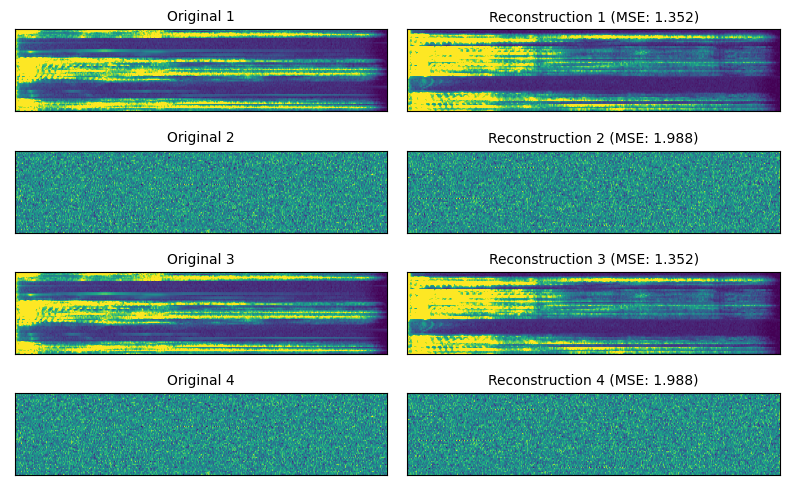

In [258]:
import torch.nn.functional as F

fig, axes = plt.subplots(4, 2, figsize=(8,5))

# for each dimension
for i in range(4):
    mse = F.mse_loss(X[:,i,:,:], X_hat[:,i,:,:])
    ax1 = axes[i, 0].imshow(X[:,i,:,:].detach().squeeze().numpy(), vmin=-1, vmax=1, aspect='auto')
    ax2 = axes[i, 1].imshow(X_hat[:,i,:,:].detach().squeeze().numpy(), vmin=-1, vmax=1, aspect='auto')

    axes[i, 0].set_title(f"Original {i+1}", fontsize=10)
    axes[i, 1].set_title(f"Reconstruction {i+1} (MSE: {mse.item():.4})", fontsize=10)

    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# fig.subplots_adjust(right=.85)
# cbar_ax = fig.add_axes([.9, 0.15, 0.05, 0.7])
# fig.colorbar(ax1, cax=cbar_ax)

plt.tight_layout()
# plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")
plt.colorbar()
plt.show()

In [ ]:
print(X.std())